## Fig. 2 panel B heatmap

This notebook:
- Loads an enrichment table and preprocess it. The preprocessed results are used in subsequent notebooks
- Compute the distance between each pair of PGs
- Plots the distance as a heatmap.   

Notes:  
- All distance calculations are done prior to plotting
- Once the calculations are done, plotting can be repeatedly executed to explore different plotting parameters.  
- Clustering the rows/columns is part of the plotting process, and it takes ~ 3 minutes  
- Rendering the heatmap takes ~ 2 minutes  
- Result files are written to a folder named `output`


In [1]:
import os, sys, itertools
from pathlib import Path
import bokeh.palettes
import matplotlib.pyplot as plt
import pandas as pd
import plotly.io as pio
import scipy
import scipy.cluster.hierarchy as sch
from matplotlib.patches import Patch
import seaborn as sns
sns.set_theme(color_codes=True)
plt.rcParams["pdf.fonttype"] = 42

script_path = Path.cwd().parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent / "data"
sys.path.append(str(script_path))
from pyseus.plotting import plotly_umap as pu
from utils.label_processing import attach_annotations
from utils.distance import calc_all_dist_mat

outputdir = f"output"
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

## Prep work

### Load the enrichment table

In [2]:
%store -r timestamp
print(f"Timestamp: {timestamp}")  

Timestamp: 2023-10-21-imp5-for-figures


In [3]:
# define files to load
enrichment_dir = Path.cwd().parent.parent / "enrichment"
enrichment_csv_path = enrichment_dir / "output" / "enrichment_and_volcano_tables" / f"{timestamp}_enrichment_table_NOC_prop.csv"

try:
    # load the file
    enrichments = pd.read_csv(enrichment_csv_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {enrichment_csv_path} not found.\nPlease run the enrichment analysis first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {enrichment_csv_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
# attach canonical gene names
gene_name_csv = data_path / "external" / "canonical_names_and_Itzhak_data.csv"
lookup_table = pd.read_csv(gene_name_csv)
to_df = enrichments["metadata"].copy()
list_of_cols_to_add = reversed(["Gene_name_canonical"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="Majority protein IDs", to_on="Majority protein IDs")
    enrichments[("metadata", "Gene_name_canonical")] = new_col_data

# attach ground truth
ground_truth_csv = data_path / "external" / "curated_ground_truth_v9.0.csv"
lookup_table = pd.read_csv(ground_truth_csv)
to_df = enrichments["metadata"].copy()
list_of_cols_to_add = reversed(["compartment"])
for c in list_of_cols_to_add:
    new_col_data = attach_annotations(from_df=lookup_table, to_df=to_df, anno_col=c, from_on="gene_name_canonical", to_on="Gene_name_canonical")
    enrichments[("metadata", "curated_ground_truth_v9.0")] = new_col_data


### Sample exclusion

In [5]:
# remove non-relavent samples from the mass spectrometry master file
# remove infected IPs from the mass spectrometry master file as it shouldn't be used in calculating the reference UMAP
cols = list(enrichments["sample"])
meta_cols = list(enrichments["metadata"])
samples = [
    x for x in cols
    if "WT" not in x # remove WTs as they represent background binding
    and "harsh" not in x # remove samples tagged with "harsh"
    and "unsorted" not in x # remove unsorted samples
    and "Infected" not in x # remove the infected samples (these are present because they are processed together in the same MaxQuant run)
]

In [6]:
# check the samples
print(f"the number of selected samples is {len(samples)}")
print(f"the selected samples are {sorted(samples)}")

the number of selected samples is 71
the selected samples are ['01-CAPRIN1', '02-ATG101', '02-COPE', '02-DCP1A', '02-GOLGA2', '02-RICTOR', '03-EXOC2', '03-HSP90AA', '03-HSPA1B', '03-SEC23A', '05-CAV1', '05-EDC4', '05-NCLN', '06-ATP6V1B2', '06-CCDC47', '06-CSNK2A1', '06-CSNK2A2', '06-YWHAB', '07-AP4B1', '07-CLTA', '07-COG8', '07-RAPTOR', '09-ATG101', '09-EDC4', '09-HSP90AA1', '09-PEX3', '09-PSMB7', '09-TOMM20', '10-AP2B1', '10-EXOC2', '10-RTN4', '10-TOMM20', '10-VPS35', '11-CEP350', '11-EEA1', '11-GPR107', '11-SEC31A', '12-ACTB', '12-G3BP1', '12-LAMP1', '12-PNPLA2', '12-RTN4', '12-SEC61B', '12-TOMM20', '12-YWHAQ', '13-GOLGA2', '13-RAB11A', '13-RAB14', '13-RAB1A', '13-RAB7A', '14-COPE', '14-GOLGA2', '14-RAB11A', '14-RAB14', '14-RAB1A', '14-RAB7A', '15-G3BP1', '15-GOLGA2', '15-LAMP1', '15-MAP1LC3B', '15-SEC61B', '15-TOMM20', '17-ATP1B3', '17-CAPRIN1', '17-G3BP1', '17-MAP1LC3B', '17-RPL36', '17-SLC30A2', 'NOC_cytosol', 'NOC_nuclear', 'NOC_organelle']


In [7]:
# remove non-informative IPs from the mass spectrometry master file; these correspond to IPs for soluble targets that peripherally bind membranes
# these IPs were not successful at pulling down membrane compartments, and were therefore removed from subsequent analyses
to_drop = ["06-ATP6V1B2","06-CSNK2A1", "06-CSNK2A2", "07-AP4B1", '02-RICTOR', "07-RAPTOR", "10-AP2B1", "12-PNPLA2", "03-EXOC2", "10-EXOC2"]
selected_samples = [x for x in samples if x not in to_drop] 

In [8]:
# check the selected samples after manual sample removal
print(f"the number of selected samples is {len(selected_samples)}")
print(f"the selected samples are {sorted(selected_samples)}")

the number of selected samples is 61
the selected samples are ['01-CAPRIN1', '02-ATG101', '02-COPE', '02-DCP1A', '02-GOLGA2', '03-HSP90AA', '03-HSPA1B', '03-SEC23A', '05-CAV1', '05-EDC4', '05-NCLN', '06-CCDC47', '06-YWHAB', '07-CLTA', '07-COG8', '09-ATG101', '09-EDC4', '09-HSP90AA1', '09-PEX3', '09-PSMB7', '09-TOMM20', '10-RTN4', '10-TOMM20', '10-VPS35', '11-CEP350', '11-EEA1', '11-GPR107', '11-SEC31A', '12-ACTB', '12-G3BP1', '12-LAMP1', '12-RTN4', '12-SEC61B', '12-TOMM20', '12-YWHAQ', '13-GOLGA2', '13-RAB11A', '13-RAB14', '13-RAB1A', '13-RAB7A', '14-COPE', '14-GOLGA2', '14-RAB11A', '14-RAB14', '14-RAB1A', '14-RAB7A', '15-G3BP1', '15-GOLGA2', '15-LAMP1', '15-MAP1LC3B', '15-SEC61B', '15-TOMM20', '17-ATP1B3', '17-CAPRIN1', '17-G3BP1', '17-MAP1LC3B', '17-RPL36', '17-SLC30A2', 'NOC_cytosol', 'NOC_nuclear', 'NOC_organelle']


### Data preprocessing

In [9]:
# finalize the table
enrich_table = enrichments.droplevel(0, axis=1)[meta_cols + selected_samples].copy()
# normalization and UMAP algorithm are not compatible with any NaN values, so drop them
enrich_table = enrich_table.dropna(subset=selected_samples)
quants = enrich_table[selected_samples].copy()
print(f"the dimensions of the data table are {quants.shape}")
# scale the data
scaled = pu.scale_table(matrix=quants, method="standard")

# save the scaled data
scaled_path = os.path.join(outputdir, f"{timestamp}_scaled_data.csv")
scaled_df = pd.DataFrame(scaled, index=enrich_table["Gene_name_canonical"], columns=enrich_table.iloc[:,5:].columns)
scaled_df.to_csv(scaled_path)

the dimensions of the data table are (8541, 61)


### Calculate distance matrices
this section calculates distance using all possible distance metrics, and takes about 2 minutes  
feel free to remove some of the metrics from the method_list to speed up calculations

In [10]:
# compute distance matrices
distMats = calc_all_dist_mat(data=scaled)

### Helper functions for plotting

In [11]:
def make_plot_dfs(distMat, merged_umap_table, annot_col):
    '''
    This function takes in one distrance matrix and the merged umap table and returns two dataframes for plotting
    subsets the data for plotting, retain only those with labels
    returns:
    df_plot: distance matrix dataframe for plotting
    df_annots_plot: metadata dataframe for color mapping   
    '''
    # dedup the table based on genes
    merged_umap_table_noDup = merged_umap_table.drop_duplicates(subset='Gene_name_canonical', keep='first')

    # construct metadata dataframe
    cols_to_exclude = enrichments["sample"].columns.to_list()
    df_annots = merged_umap_table_noDup[[col for col in merged_umap_table_noDup.columns if col not in cols_to_exclude]]

    df_annots[annot_col] = df_annots[annot_col].fillna("undef")

    # construct distance matrix dataframe
    # subset the distance matrix to only include the genes in the deduped matrix
    df_dist = distMat[merged_umap_table_noDup.index,:][:,merged_umap_table_noDup.index]
    df_dist = pd.DataFrame(df_dist, index=merged_umap_table_noDup["Gene_name_canonical"], columns=merged_umap_table_noDup["Gene_name_canonical"])

    # subset the data for plotting, retain only those with labels
    idx = df_annots[annot_col] != "undef"
    df_annots_plot = df_annots[idx].copy()
    df_plot = df_dist.loc[df_annots_plot["Gene_name_canonical"]]
    df_plot = df_plot[df_annots_plot["Gene_name_canonical"]]

    # create color palette
    orgnaelle_uni = list(set(df_annots_plot[annot_col]))
    orgnaelle_uni.sort() # consistent legend
    # get the Category20 colors and create an iterator to cycle through them
    category20_colors = bokeh.palettes.Category20[20]
    color_iterator = itertools.cycle(category20_colors)
    # create a list to store your 27 colors
    colors = []
    # append colors to the list for each category
    for _ in range(len(orgnaelle_uni)):
        colors.append(next(color_iterator))
    orgnaelle_color_pal = colors # 27 colors with expert annotation

    Organelle2color = {}
    for idx, ogranelle in enumerate(orgnaelle_uni):
        Organelle2color[ogranelle] = orgnaelle_color_pal[idx]

    # replace orgranelle names with colors
    df_annots_plot["color"] = df_annots_plot[annot_col].apply(lambda x: Organelle2color[x])
    #
    df_annots_plot.set_index("Gene_name_canonical", inplace=True)

    return df_plot, df_annots_plot, Organelle2color

## Plot the distance heatmap
Once the prep work section (above) has been executed once, this section can be repeatly executed to explore plotting options. It is advied to execute the whole plotting section each time.

### define heatmap parameters (aesthetics are in a later cell)

In [12]:
# distance metric used to calculate the protein pair-wise distance (using their enrichment vectors). This distance is shown in the heatmap
distance_metric1 = "correlation"
# row/column clusetering parameters
distance_metric2 = "cosine"  # distance mertic used for clustering, **NOT** for calculating distance using enrichment table
linkage_method = "average"  # linkage method used for clustering, "averge" tends to work better than 'complete' for our data

# name of the annotation column, the info is shown in the sidebar of the heatmap
# note that PGs with nan, undef labels will be removed
annotation_col = "curated_ground_truth_v9.0"

### More prep work (adjusting dataframes and clustering rows/columns)

In [13]:
# prepare the dataframes for plotting
df_plot, df_annots_plot, Organelle2color = make_plot_dfs(distMat=distMats[distance_metric1], merged_umap_table=enrich_table, annot_col=annotation_col)

# add numeric index to the dataframes
df_annots_plot.index = pd.RangeIndex(len(df_annots_plot.index))
df_plot.index = pd.RangeIndex(len(df_plot.index))

In [14]:
# cluster rows and columns (takes a few minutes to run)

# compute distance matrix for clustering
distance_matrix = sch.linkage(df_plot, method=linkage_method, metric=distance_metric2)  # Hierarchical clustering

# Reorder rows and columns based on clustering results
row_order = sch.dendrogram(distance_matrix, no_plot=True, orientation='bottom')['leaves']
col_order = sch.dendrogram(distance_matrix, no_plot=True, orientation='top')['leaves']

# apply the final order
data_reordered = df_plot.iloc[row_order, col_order]

# make the column index name the same as that of the row index
# make the column names the same as the row index, else the row colors won't work
gene_names = data_reordered.columns
data_reordered.index.name = data_reordered.columns.name 
data_reordered.columns = data_reordered.index 

# row and column colors
df_annots_plot_sorted_by_row = df_annots_plot.iloc[row_order] # sort the annotation dataframe by the row order
clut = Organelle2color
row_colors = df_annots_plot_sorted_by_row[annotation_col].map(clut)

df_annots_plot_sorted_by_col = df_annots_plot.iloc[col_order] # sort the annotation dataframe by the col order
clut = Organelle2color
col_colors = df_annots_plot_sorted_by_col[annotation_col].map(clut)


C:\Users\duo.peng\AppData\Local\Temp\ipykernel_18948\1857863584.py:4: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



### Plotting the heatmap

#### Aesthetics here

In [15]:
# adjust contrast, following Manu's suggestions
data_reordered = data_reordered.where(data_reordered > 0.4, 0.4)
data_reordered = data_reordered.where(data_reordered < 0.9, 0.9)

In [16]:
# color palette
pal = "Blues"  # For other options, see this page: https://matplotlib.org/stable/users/explain/colors/colormaps.html
reverse_pal = True  # Whether to **reverse** the color palette

if reverse_pal:  # reverse the color palette if boolean is True
    pal = pal + "_r"

the sns command is in the following cell

<Figure size 640x480 with 0 Axes>

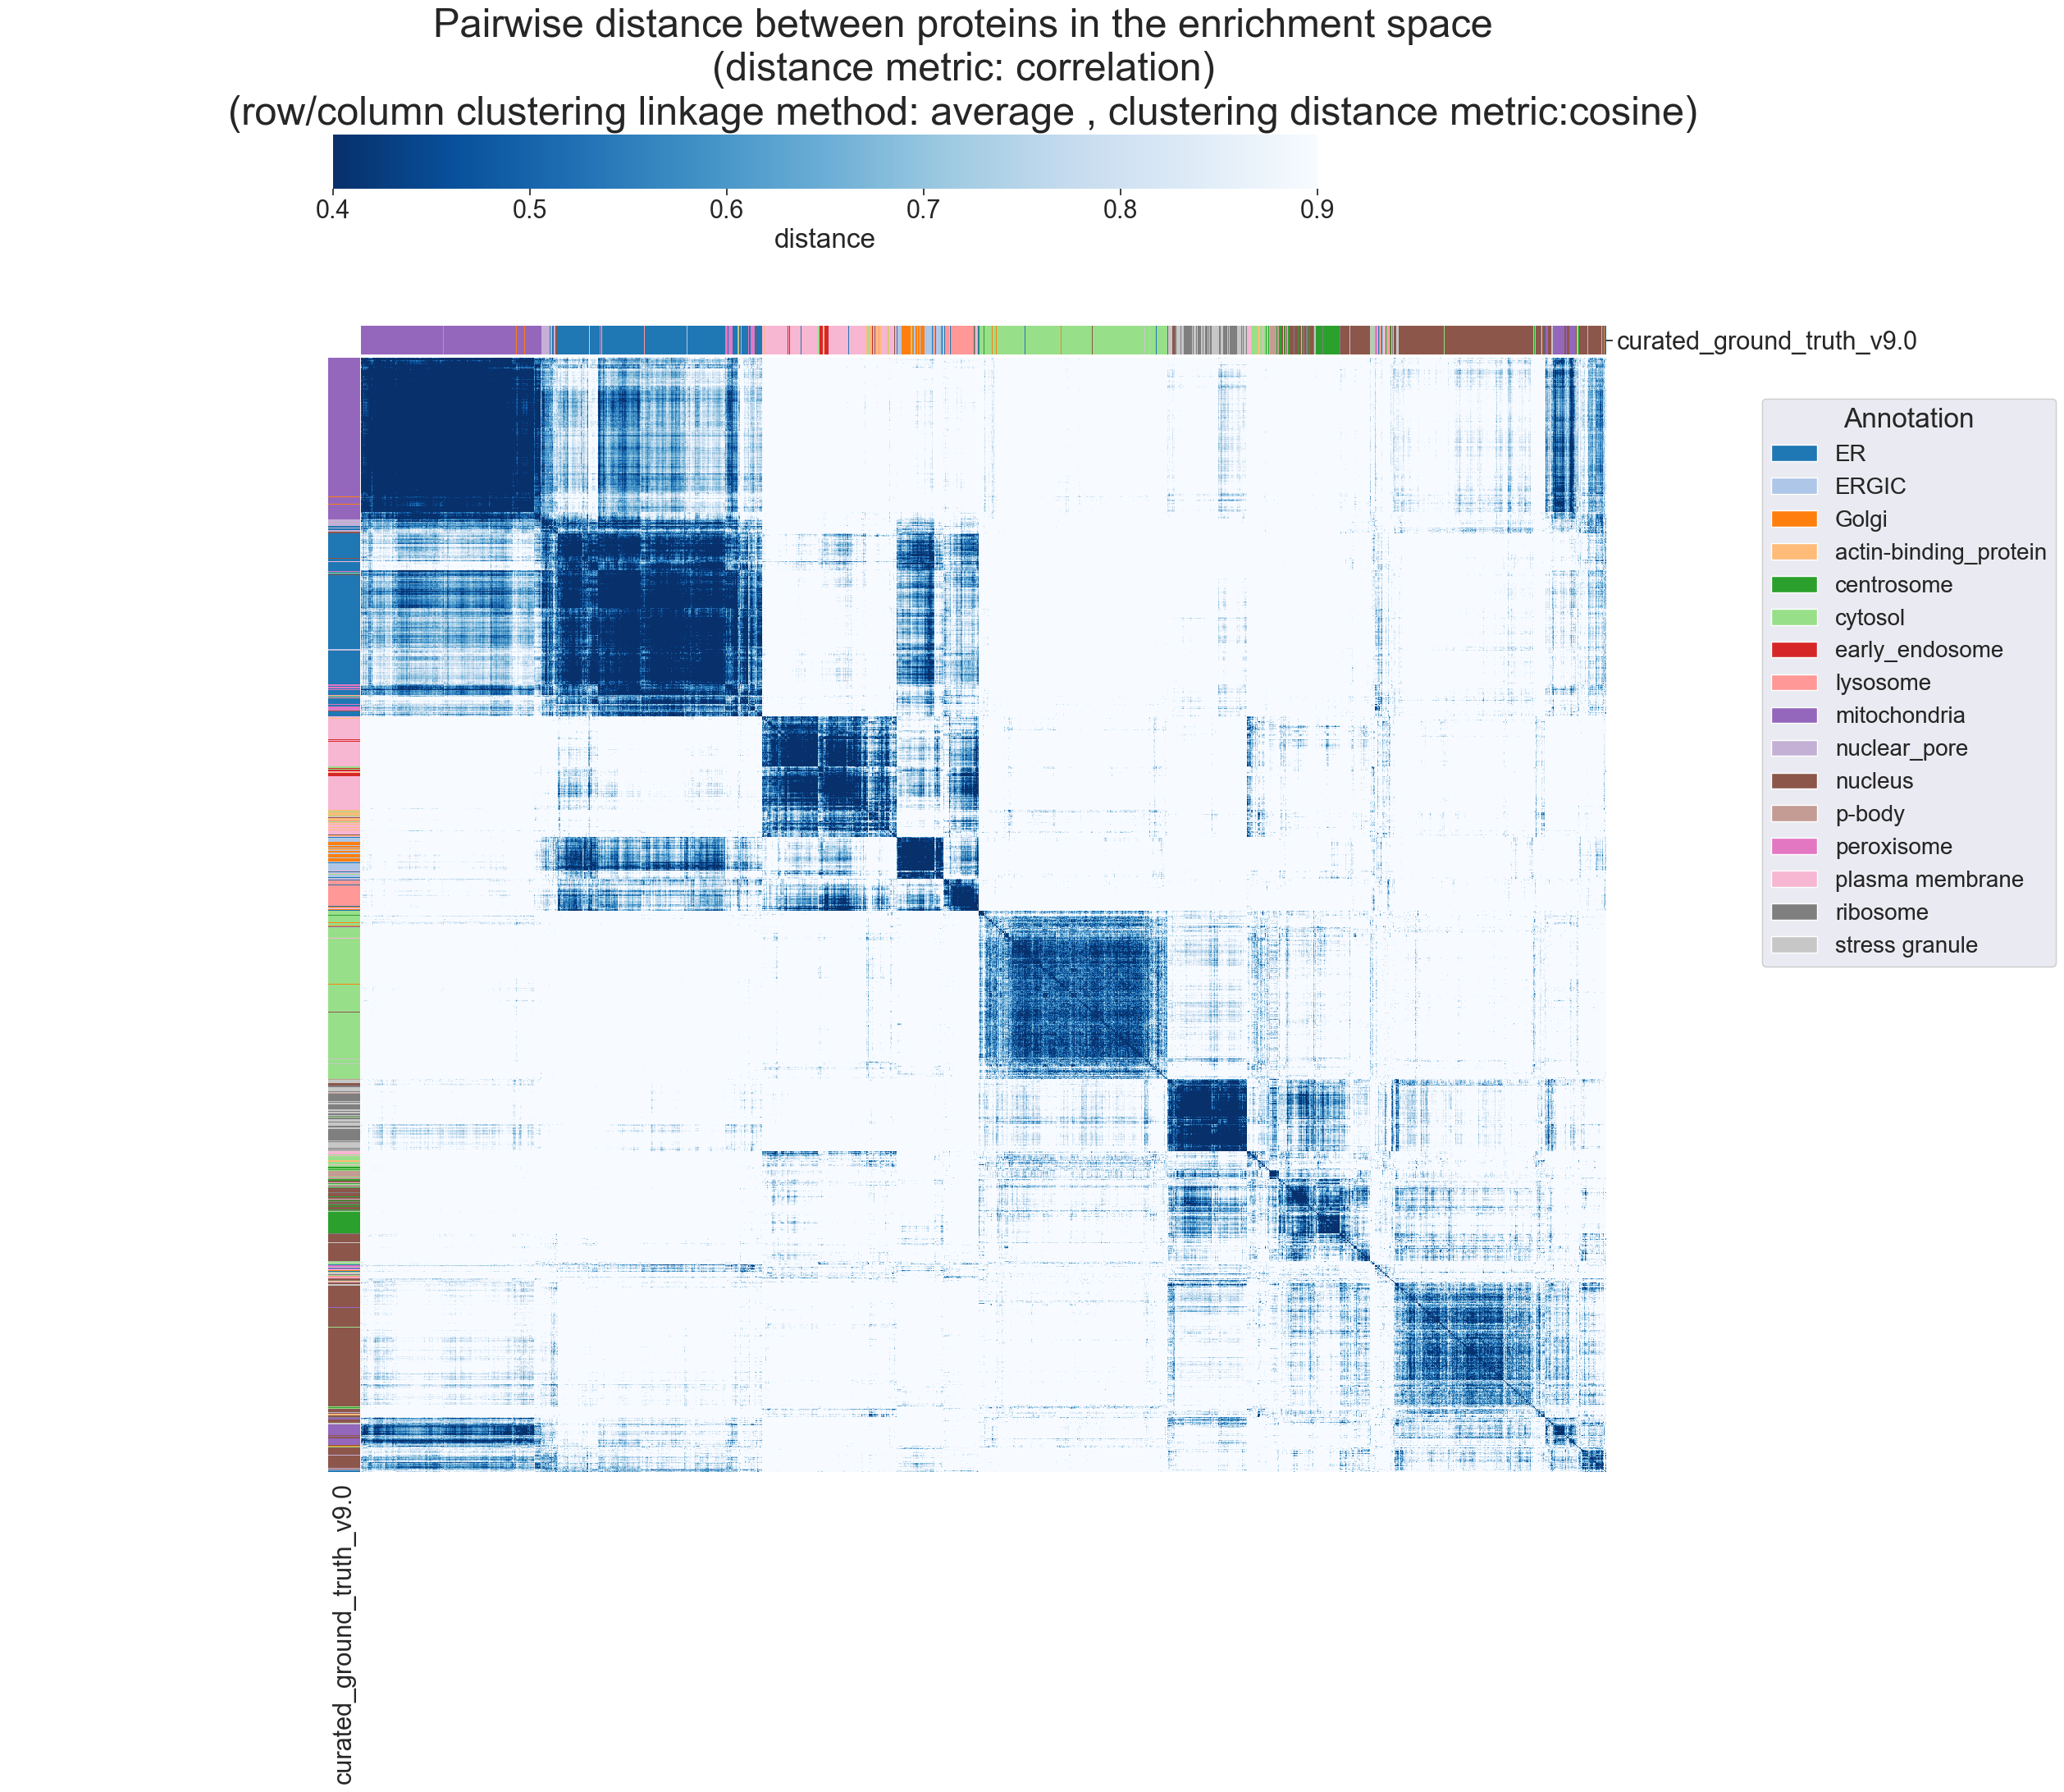

In [17]:
# plot the heatmap with seaborn (using precomputed clusters. Using seaborn to cluster rows/cols takes forever)
# takes 1-2 minutes to run
plt.clf()
sns.set(font_scale=2)
g = sns.clustermap(
    data=data_reordered,
    cmap=sns.color_palette(pal, as_cmap=True), row_colors=row_colors, col_colors=col_colors,
    row_cluster=False, col_cluster=False,
    colors_ratio=(0.02, 0.02),  # width of color bar
    cbar_pos=(0.18, 0.9, 0.5, 0.03),  # color bar location coordinates in this format (left, bottom, width, height),
    # cbar_pos=None,
    cbar_kws={"orientation": "horizontal", "label": f"distance", "extend": "neither"},
    robust=True, figsize=(24, 22), xticklabels=False, yticklabels=False,
)

g.fig.suptitle(
    f"Pairwise distance between proteins in the enrichment space\n(distance metric: {distance_metric1})\n(row/column clustering linkage method: {linkage_method} , clustering distance metric:{distance_metric2})",
    fontsize=35, y=1.00,
)
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

# row/col colors legend
clut1 = Organelle2color
handles = [Patch(facecolor=clut1[name]) for name in clut1]
col_legend1 = plt.legend(
    handles, clut1,
    title="Annotation",
    bbox_to_anchor=(0.9, 0.79), bbox_transform=plt.gcf().transFigure,
    loc="upper left", fontsize=20,
)
plt.gca().add_artist(col_legend1)

plot_name = f"shownDist={distance_metric1}_ClusterDist={distance_metric2}_Linkage={linkage_method}"
plt.savefig(f"{outputdir}/{plot_name}.png", bbox_inches="tight", format="png", dpi=300)

### Interactive htmls
produce interactive versions of the heatmap (using plotly)  


In [18]:
# Optional: plot interactive html in 4 chunks

# load required library for this part
import dash_bio


# define a function to split data into n chunks (to avoid producing a huge html file that won't open)
def split_range_into_chunks(start, end, num_chunks):
    """Splits a range into num_chunks chunks and returns the start and end of each chunk."""
    chunk_size, remainder = divmod(end - start, num_chunks)
    chunks = []
    current_start = start
    for i in range(num_chunks):
        # If there's remainder, add one more to the chunk size
        current_end = current_start + chunk_size + (1 if i < remainder else 0)
        chunks.append((current_start, current_end - 1))  # Subtract 1 to get the last item in the current range
        current_start = current_end
    return chunks


# split the data into n chunks 
chunks = split_range_into_chunks(0, data_reordered.shape[0] - 1, num_chunks=1)

# plot the heatmap with plotly an save as an html file
plot_name = f"shownDist={distance_metric1}_ClusterDist={distance_metric2}_Linkage={linkage_method}"
for idx, chunk in enumerate(chunks):
    data = data_reordered.iloc[chunk[0] : chunk[1], chunk[0] : chunk[1]]
    clustergram = dash_bio.Clustergram(
        data=data.iloc[::-1, :],  # reverse the order of the rows, b/c for some reason the order is reversed in the plotly heatmap
        column_colors=col_colors.tolist()[chunk[0] : chunk[1]],
        row_colors=row_colors.tolist()[chunk[0] : chunk[1]][::-1],  # reverse the order of the rows
        column_labels=gene_names.tolist()[chunk[0] : chunk[1]],  # hover x labels
        row_labels=gene_names.tolist()[chunk[0] : chunk[1]][::-1],  # hover y labels # reverse the order of the rows
        height=1000, width=1200,
        cluster=False,
        color_map=pal,
        hidden_labels=["row", "col"],
        # generate_curves_dict= True,
        # return_computed_traces= True
    )
    pio.write_html(
        clustergram,
        file=os.path.join(outputdir, f"{plot_name}_chunk{idx+1}.html"),
        auto_open=False,
    )